In [75]:
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm

from factor_analyzer import FactorAnalyzer

import yfinance as yf

In [17]:
import sys
sys.path.append('../') # go to parent dir
sys.path.append('/home/artem/git/sdafe')

In [63]:
from sdafe.plot import abs_diff_heatmap
from sdafe.ch12.unitroot import adf_test
from sdafe.ch18.pca import princomp
from sdafe.ch18.factors import evaluate_factors

#### Exercise 1

In [11]:
data = pd.read_csv('daily-treasury-rates.csv', index_col=0, parse_dates=[0])
data.head()

,1 Mo,3 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr
Date,,,,,,,,,,,
2009-12-31,0.04,0.06,0.20,0.47,1.14,1.70,2.69,3.39,3.85,4.58,4.63
2009-12-30,0.02,0.05,0.19,0.45,1.08,1.65,2.61,3.34,3.80,4.54,4.61
2009-12-29,0.02,0.10,0.20,0.47,1.09,1.64,2.62,3.33,3.82,4.57,4.64
2009-12-28,0.03,0.11,0.20,0.47,1.09,1.63,2.62,3.34,3.85,4.61,4.69
2009-12-24,0.02,0.05,0.18,0.43,1.00,1.56,2.57,3.32,3.82,4.60,4.68


In [12]:
delta_yield = data.diff().dropna()

Check the short-term interest rate:

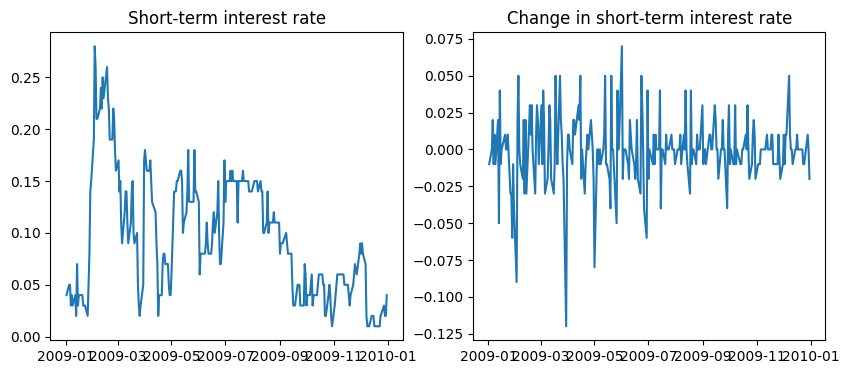

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].plot(data.iloc[:, 0]);
axs[0].set_title('Short-term interest rate');
axs[1].plot(delta_yield.iloc[:, 0]);
axs[1].set_title('Change in short-term interest rate');

We check the stationarity of the yield time series and the diffs:

In [24]:
pd.DataFrame([adf_test(data[col])[1] for col in data.columns], index=data.columns, columns=['p-value'])

,p-value
1 Mo,0.147566
3 Mo,0.698188
6 Mo,0.887279
1 Yr,0.914037
2 Yr,0.282147
3 Yr,0.562064
5 Yr,0.698945
7 Yr,0.735536
10 Yr,0.818289
20 Yr,0.890624


In [25]:
pd.DataFrame([adf_test(delta_yield[col])[1] for col in data.columns], index=data.columns, columns=['p-value'])

,p-value
1 Mo,2.696300e-08
3 Mo,1.109156e-06
6 Mo,4.596294e-07
1 Yr,7.974768e-07
2 Yr,6.675998e-08
3 Yr,2.060580e-07
5 Yr,1.719153e-06
7 Yr,8.325741e-07
10 Yr,2.580440e-07
20 Yr,6.102154e-07


Five principal components are sufficient to account for 98% of the variance:

In [27]:
res = princomp(delta_yield)
res.summary()

,Comp.1,Comp.2,Comp.3,Comp.4,Comp.5,Comp.6,Comp.7,Comp.8,Comp.9,Comp.10,Comp.11
Standard deviation,0.194179,0.055121,0.028969,0.023879,0.017193,0.016107,0.012922,0.011988,0.010538,0.009988,0.008578
Proportion of Variance,0.870729,0.070163,0.019380,0.013168,0.006826,0.005991,0.003856,0.003319,0.002565,0.002304,0.001699
Cumulative Proportion,0.870729,0.940892,0.960272,0.973440,0.980266,0.986258,0.990114,0.993432,0.995997,0.998301,1.000000


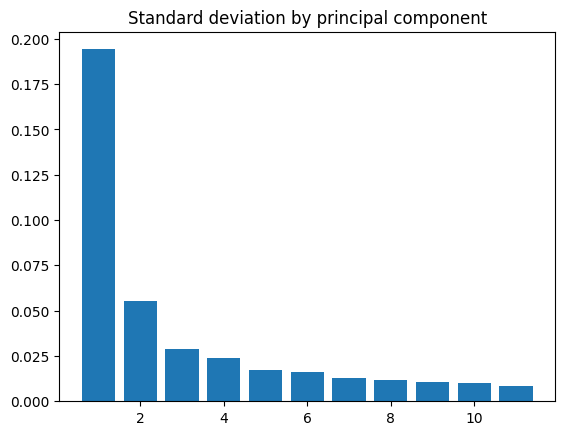

In [34]:
fig, ax = plt.subplots()
ax.bar(np.arange(1, len(res.sdev) + 1), height=res.sdev);
ax.set_title('Standard deviation by principal component');

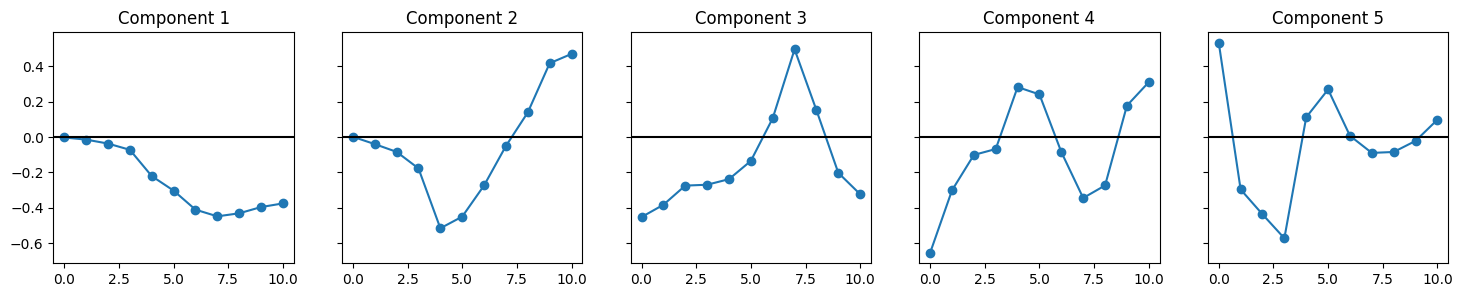

In [42]:
fig, axs = plt.subplots(1, 5, figsize=(18, 3), sharey=True)
for i in range(5):
    axs[i].plot(res.loadings[:, i], '-o');
    axs[i].set_title(f'Component {i+1}');
    axs[i].axhline(0, color='black');

Possible interpretation of the first three components:
   * Component 1: long-term interest rates,
   * Component 2: medium-term interest rates vs long-term interest rates,
   * Component 3: the convexity of the curve.

#### Exercise 2

In [49]:
data = pd.read_csv('../data/midcapD.ts.csv', index_col=0, parse_dates=[0])
data.head()

,LSCC,CSGS,EC,NYB,ALTR,APH,CLS,NET,SBUX,AYE,...,SBL,PCZ,OSI,TRP,ROH,SU,MTD,RAD,GUC,market
X.Y..m..d,,,,,,,,,,,,,,,,,,,,,
2000-01-03,0.031167,0.051724,-0.019868,-0.009217,0.058008,0.010329,-0.040541,-0.016393,0.016753,-0.037123,...,-0.000983,-0.021739,-0.019277,0.007143,-0.007680,-0.017964,-0.073650,0.067416,0.002183,-0.007124
2000-01-04,-0.075241,-0.023845,-0.050676,-0.032558,-0.050060,-0.034387,-0.115023,-0.064286,-0.031686,0.012048,...,-0.083661,-0.017778,0.007371,-0.014184,-0.017028,0.033537,-0.021201,-0.042105,-0.032135,-0.039521
2000-01-05,-0.025730,-0.003053,0.021352,-0.002404,-0.011292,-0.022137,-0.071618,0.012723,0.013089,0.045238,...,-0.066595,0.063348,0.000000,0.000000,0.061417,0.085546,-0.021661,-0.021978,-0.018571,-0.000856
2000-01-06,-0.049251,-0.050536,0.027875,0.002410,-0.025381,-0.027559,0.002857,-0.042714,0.036176,-0.009112,...,-0.024166,-0.021277,-0.004878,0.000000,0.037092,-0.027174,0.022140,-0.033708,-0.018349,-0.007353
2000-01-07,0.041291,-0.008065,0.013559,0.002404,0.104167,0.010121,0.048433,0.055118,-0.004988,0.002299,...,-0.003538,-0.004348,-0.031863,-0.035971,0.072961,0.006983,0.028881,0.023256,0.032710,0.032511


Six factors appear to be sufficient at 5%:

In [54]:
evaluate_factors(data)

,Statistic,df,p-value
Factors,,,
1,9.655221e+02,189,0.000000e+00
2,5.445990e+02,169,0.000000e+00
3,3.736250e+02,150,0.000000e+00
4,2.333247e+02,132,1.295496e-07
5,1.536785e+02,115,9.312804e-03
6,1.061694e+02,99,2.929383e-01
7,8.663851e+01,84,4.002104e-01
8,6.387510e+01,70,6.832351e-01
9,4.464226e+01,57,8.829463e-01


In [56]:
n_factors = 6
fa = FactorAnalyzer(n_factors=n_factors, rotation=None, method='ml')
fa.fit(data);

The estimate of the correlation matrix from the model is:

In [58]:
corr_model = pd.DataFrame(fa.loadings_ @ fa.loadings_.T + np.diag(fa.get_uniquenesses()), index=data.columns, columns=data.columns)
corr_model

,LSCC,CSGS,EC,NYB,ALTR,APH,CLS,NET,SBUX,AYE,...,SBL,PCZ,OSI,TRP,ROH,SU,MTD,RAD,GUC,market
LSCC,1.000000,0.213568,0.184058,0.073045,0.793882,0.475912,0.583783,0.453144,0.274111,-0.071237,...,0.399633,-0.027751,0.185827,-0.049389,0.144106,-0.035583,0.230249,0.133187,0.211606,0.689725
CSGS,0.213568,1.000000,0.068555,0.029545,0.195701,0.200085,0.237465,0.057404,0.046392,0.010600,...,0.177153,0.012953,0.039791,-0.023447,0.038369,-0.017418,0.144295,-0.012049,0.111083,0.235336
EC,0.184058,0.068555,1.000000,0.237999,0.201009,0.184314,0.184690,0.102717,0.219919,0.192293,...,0.141750,0.057835,0.246188,0.048799,0.546680,0.056651,0.156041,0.089188,0.149233,0.395391
NYB,0.073045,0.029545,0.237999,1.000000,0.115897,0.063499,0.090041,0.057456,0.242165,0.158372,...,0.051980,0.046799,0.151984,0.089452,0.218257,0.035850,0.166130,0.023450,0.069908,0.264006
ALTR,0.793882,0.195701,0.201009,0.115897,1.000000,0.381450,0.539353,0.355009,0.346499,-0.037246,...,0.348405,-0.045950,0.163389,-0.041613,0.168343,-0.034918,0.252110,0.116475,0.125569,0.657971
APH,0.475912,0.200085,0.184314,0.063499,0.381450,1.000000,0.459669,0.338889,0.152536,-0.026197,...,0.336610,-0.000281,0.164938,-0.031407,0.148830,-0.039398,0.192981,0.086852,0.236572,0.539361
CLS,0.583783,0.237465,0.184690,0.090041,0.539353,0.459669,1.000000,0.360886,0.215105,-0.027503,...,0.380851,-0.018660,0.172724,-0.033313,0.134573,-0.066402,0.248433,0.086027,0.241782,0.624914
NET,0.453144,0.057404,0.102717,0.057456,0.355009,0.338889,0.360886,1.000000,0.207833,-0.068447,...,0.245791,0.022323,0.186361,0.008396,0.070600,0.039278,0.098131,0.148790,0.183348,0.494341
SBUX,0.274111,0.046392,0.219919,0.242165,0.346499,0.152536,0.215105,0.207833,1.000000,0.112207,...,0.126549,0.019621,0.187159,0.083880,0.183184,0.011306,0.203251,0.067401,0.093347,0.420432
AYE,-0.071237,0.010600,0.192293,0.158372,-0.037246,-0.026197,-0.027503,-0.068447,0.112207,1.000000,...,-0.021737,0.121146,0.086079,0.078641,0.190267,0.155957,0.101514,-0.018772,0.026694,0.078032


In [61]:
corr_sample = data.corr()

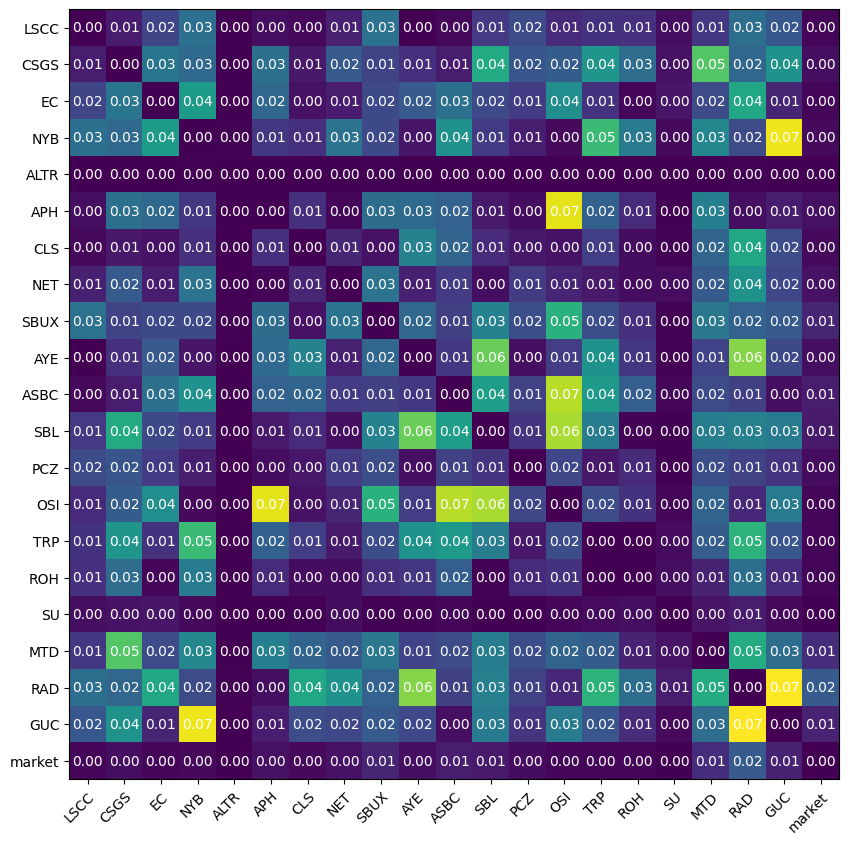

In [66]:
fig, ax = plt.subplots(figsize=(10, 10))
abs_diff_heatmap(corr_model, corr_sample, ax)

#### Exercise 3

Since
$$R_{j,t} = \beta_{0,j} + \beta_{1,j} F_{1,t} + \beta_{2,j} F_{2,t} +\epsilon_{j,t}$$
and
$$R_{j',t} = \beta_{0,j'} + \beta_{1,j'} F_{1,t} + \beta_{2,j'} F_{2,t} +\epsilon_{j,t}$$
we have
$$
\mathrm{Cov}(R_{j,t}, R_{j',t}) 
= \mathrm{Cov}(\beta_{0,j} + \beta_{1,j} F_{1,t} + \beta_{2,j} F_{2,t} +\epsilon_{j,t}, \beta_{0,j'} + \beta_{1,j'} F_{1,t} + \beta_{2,j'} F_{2,t} +\epsilon_{j,t})
= \beta_{1,j} \beta_{1,j'} \mathrm{Var}(F_{1,t}) + \beta_{2,j} \beta_{2,j'} \mathrm{Var}(F_{2,t}) + (\beta_{1,j} \beta_{2,j'} + \beta_{1,j'} \beta_{2,j}) \mathrm{Cov}(F_{1,t}, F_{2,t})
$$

#### Exercise 4

In [115]:
data = pd.read_csv('../data/equityFunds.csv', index_col=0, parse_dates=[0])
data.head()

,EASTEU,LATAM,CHINA,INDIA,ENERGY,MINING,GOLD,WATER
X.Y..m..d,,,,,,,,
2002-01-01,0.000000,0.000000,0.000000,0.000000,-0.007110,0.000000,0.000000,-0.000449
2002-01-02,0.007641,-0.000717,0.000000,0.044040,0.000000,0.002605,0.006192,0.015940
2002-01-03,0.017450,0.004292,0.021740,0.015410,0.000000,0.001733,0.009828,-0.021080
2002-01-04,0.041210,0.022580,0.008921,0.007373,-0.015860,0.014610,0.015770,0.002811
2002-01-07,0.002241,-0.005598,0.017610,0.024190,0.006667,0.008496,0.005999,0.001152


Three components are enough to account for 95% of the variance:

In [117]:
res = princomp(data)
res.summary()

,Comp.1,Comp.2,Comp.3,Comp.4,Comp.5,Comp.6,Comp.7,Comp.8
Standard deviation,0.026421,0.015830,0.013198,0.012029,0.009682,0.007856,0.006466,0.005478
Proportion of Variance,0.466988,0.167647,0.116519,0.096804,0.062710,0.041288,0.027968,0.020077
Cumulative Proportion,0.466988,0.634635,0.751153,0.847957,0.910668,0.951956,0.979923,1.000000


The first three components:

In [119]:
pd.DataFrame(res.loadings[:, :3], index=data.columns)

,0,1,2
EASTEU,-0.357629,-0.373686,0.459350
LATAM,-0.407321,-0.259234,0.259960
CHINA,-0.165607,-0.170563,-0.074932
INDIA,-0.253795,-0.540729,-0.769303
ENERGY,-0.241585,-0.122968,0.251697
MINING,-0.482965,0.162177,0.008838
GOLD,-0.556415,0.652922,-0.240249
WATER,-0.114622,-0.062831,0.053165


The first factor is the market and the second factor is natural resources vs other funds.